# Titanic Disaster


### 目录

1. Load the dataset
2. Exploratory data analysis
3. Cleaning data
4. Building the model
5. 优化模型
6. 下一步的改进想法

In [103]:
# data analysis 
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# visualization defaults
plt.style.use('ggplot')
sns.set_style('whitegrid')

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## 1 - Load the dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 变量解释：
- Survived：存活与否，0-No，1-Yes
- Pclass：船舱等级，1-一等舱，2-二等舱，3-三等舱
- Name：姓名
- Sex：性别，只有Female和Male两种
- Age：年龄
- SibSp：同在船上的【兄弟姐妹(siblings)和配偶(spouses)】的总数
- Parch: 同在船上的【父母和孩子】的总数
- Ticket：船票的编号
- Fare：票价
- Cabin：客舱号
- Embarked：登船的港口，C = Cherbourg, Q = Queenstown, S = Southampton

## 2 - Exploratory Data Analysis

### 2.1 - 查看缺失数据

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


训练集中共有乘客891名，以下属性的数据不完整：
- Age属性有约20%的数据缺失
- Cabin有约80%的数据缺失
- Embarked有2条数据缺失

其它属性数据完整。

测试集中共有顾客418名，其中Age、Cabin缺失大量数据，Fare缺失一条数据。

### 2.2 - 查看数据分布及数据之间的关系

#### 2.2.1 - Survived

最后有约330个人活了下来，占乘客总数的37%

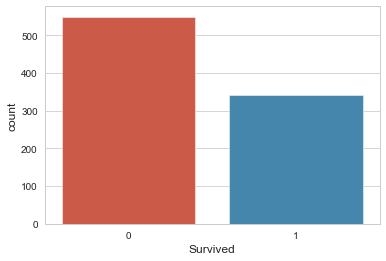

In [5]:
sns.countplot(x='Survived', data=train)

#### 2.2.2 - 名字 Name

- 名字的信息较为复杂，但名字里的“Mr"、"Mrs”等称呼和年龄有关， 如“Master”的平均年龄为4.5岁，“Miss”为22岁，“Dr”为42岁。

想法：

- 新增一个变量title，根据title填充年龄的缺失值。

In [6]:
# 提取名字里的title
train['title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [7]:
title_count = train['title'].value_counts()
title_mean_age = train.groupby('title').mean()['Age']
pd.concat([title_count, title_mean_age], axis=1, sort=True).sort_values('title', ascending=False)

,title,Age
Mr,517,32.368090
Miss,182,21.773973
Mrs,125,35.898148
Master,40,4.574167
Dr,7,42.000000
Rev,6,43.166667
Major,2,48.500000
Col,2,58.000000
Mlle,2,24.000000
Mme,1,24.000000


#### 2.2.3 - 船舱等级 Pclass

从下面的图表中可以看出:

- 存活率：一等舱 > 二等舱 > 三等舱，这说明存活率和船舱等级关系密切。
- 平均年龄：一等舱 > 二等舱 > 三等舱，这说明年龄分布与船舱等级有关。
- SibSp：三等舱 > 一等舱 ≈ 二等舱

想法：

- Pclass属性需纳入模型训练中

In [8]:
train.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


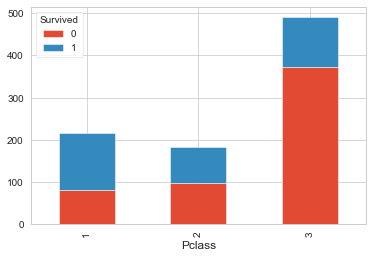

In [9]:
# 不同等级船舱乘客的存活情况
df = train.groupby(by='Pclass')['Survived'].value_counts().unstack(level=1)
df.plot(kind='bar', stacked=True)

#### 2.2.4 - 性别 Sex

- 女性的存活率明显高于男性
- 女性的平均年龄略低于男性
- 女性的SibSp和Parch平均数量均高于男性

想法：

- 性别需纳入模型训练中

In [10]:
train.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


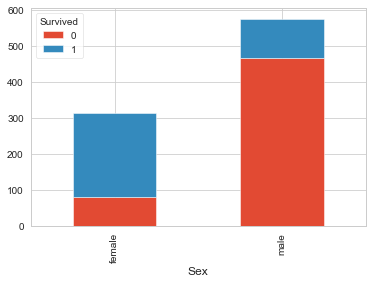

In [11]:
df = train.groupby(by='Sex')['Survived'].value_counts().unstack(level=1)
df.plot.bar(stacked=True)

#### 2.2.5 - 年龄 Age

从下图可以看出：
- 乘客年龄分布为0～80岁，大部分乘客年龄集中在15～40岁。
- 10岁以下的儿童存活率很高
- 60岁以上的死亡率很高，但年纪最大的那个80岁的人活下来了
- 随着船舱等级的上升，乘客的平均年龄增加
- 女性平均年龄略低于男性

想法:

- 根据船舱等级填补年龄的缺失值
- 将年龄从连续值变为离散值，即设置不同的年龄区间

Text(0.5, 1.0, 'Age distribution of different Sex ')

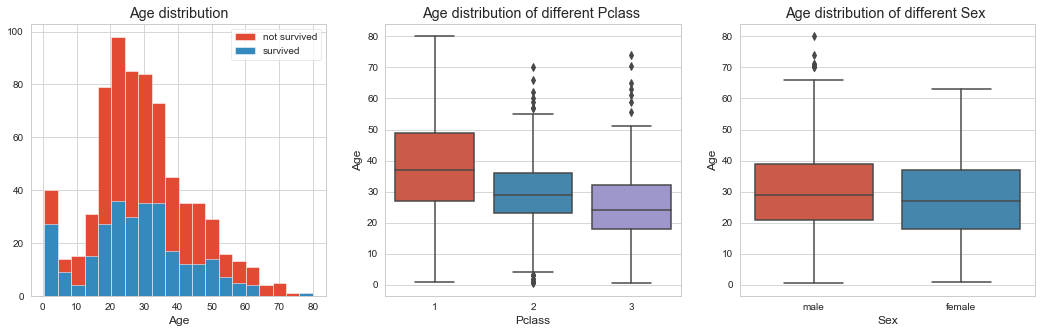

In [12]:
plt.subplots(1, 3, figsize=(18,5))

# 不同年龄区间的存活情况分布
plt.subplot(1, 3, 1)
sns.distplot(train['Age'].dropna(), kde=False, bins=20, hist_kws={"alpha": 1}, label='not survived') 
sns.distplot(train[train['Survived'] == 1]['Age'].dropna(), kde=False, bins=20, hist_kws={"alpha": 1}, label='survived') 
plt.legend()
plt.title('Age distribution')

# 不同船舱的年龄分布
plt.subplot(1, 3, 2)
sns.boxplot(x='Pclass', y='Age', data=train)
plt.title('Age distribution of different Pclass ')

# 不同性别的年龄分布
plt.subplot(1, 3, 3)
sns.boxplot(x='Sex', y='Age', data=train)
plt.title('Age distribution of different Sex ')

#### 2.2.6 - SibSp & Parch

- SibSp和Parch之间有一定的相关性，但和存活率之间的相关性较小

想法：

- SibSp和Parch的区别不大，可以考虑将两个变量合并为一个变量family_size = SibSp + Parch
- SibSp和Parch对预测结果的影响尚不明确，可以分别尝试将其纳入模型和不纳入模型，对比哪种情况下预测结果更好

In [13]:
train[['SibSp', 'Survived']].groupby('SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [14]:
train[['Parch', 'Survived']].groupby('Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [15]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


#### 2.2.7 - 票价 Fare

- 票价越高，存活率越高

想法：

- 需将票价纳入模型
- 将票价离散化，即设置不同的票价区间

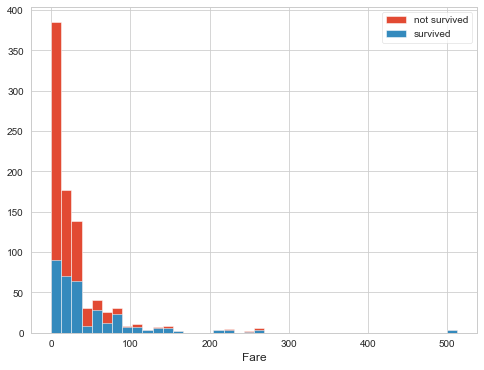

In [16]:
plt.figure(figsize=(8, 6))
sns.distplot(train['Fare'], kde=False, bins=40, hist_kws={"alpha": 1}, label='not survived') 
sns.distplot(train[train['Survived'] == 1]['Fare'], kde=False, bins=40, hist_kws={"alpha": 1}, label='survived') 
plt.legend()

#### 2.2.8 - 客舱号 Cabin

Cabin的构成为“甲板号”+“房间号”，例如B96为B甲板的第96号房间。理论上越靠近出口的客舱逃生率越高，所以Cabin对预测结果应该有影响。但是由于Cabin数据较分散，且缺失值很多，所以不太好利用。

In [17]:
train['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
D              3
              ..
A36            1
C85            1
B79            1
E12            1
B37            1
Name: Cabin, Length: 147, dtype: int64

可以考虑将Cabin分为“有信息”和“无信息"两类，然后看它和逃生率的关系：

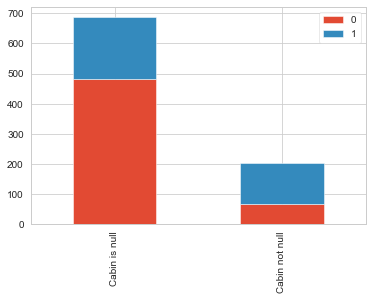

In [18]:
cabin = train['Survived'][train['Cabin'].isnull()].value_counts()
no_cabin = train['Survived'][train['Cabin'].notnull()].value_counts()
df = pd.DataFrame({'Cabin is null': cabin, 'Cabin not null': no_cabin})
df = df.stack().unstack(level=0)
df.plot.bar(stacked=True)

可见，Cabin有信息的存活率要高得多，因此可以考虑将Cabin转为类目型变量have_cabin。

#### 2.2.9 - 登船港口 Embarked

- C港口登船的乘客客舱生还率最高，Q次之，S最低。

想法：

- 将embarked纳入模型，并转换为数值变量

In [19]:
train.groupby(by='Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


## 3  - Data Cleaning

**Age:** 

- 根据title和Pclass对Age的缺失值进行填充：
    - 如果title是“Miss”/“Master”/“Dr”/“Rev”/“Rare”，按title填充缺失值；
    - 其它则按船舱等级填充缺失值。
- 设置不同的年龄区间age_band:
    - 0：0～16
    - 1：16～32
    - 2：32～48
    - 3：48～64
    - 4：64～80

In [20]:
# 将title划分为Mr、Mrs、Miss、Master、Dr、Rev、Rare七类
train['title'] = train['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['title'] = train['title'].replace(['Mlle','Ms'], 'Miss')
train['title'] = train['title'].replace('Mme', 'Mrs')

In [21]:
train.groupby('title').mean()['Age']

title
Dr        42.000000
Master     4.574167
Miss      21.845638
Mr        32.368090
Mrs       35.788991
Rare      49.100000
Rev       43.166667
Name: Age, dtype: float64

In [22]:
train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [23]:
# 填充年龄的缺失值
def ImputAge(cols):
    Age = cols[0]
    Pclass = cols[1]
    title = cols[2]
    
    if pd.isnull(Age):
        if title == 'Miss':
            return 21.8
        if title == 'Master':
            return 4.6
        if title == 'Dr':
            return 42.0
        if title == 'Rev':
            return 43.1
        if title == 'Rare':
            return 49.1
        if Pclass == 1:
            return 38.2
        if Pclass == 2:
            return 29.9
        return 25.1
    return Age

train['Age'] = train[['Age', 'Pclass', 'title']].apply(ImputAge, axis=1)

In [24]:
# 划分不同的年龄区间:
def AgeBand(age):
    if 0 < age <= 16:
        return 0
    if 16 < age <= 32:
        return 1
    if 32 < age <= 48:
        return 2
    if 48 < age <= 60:
        return 3
    return 4

train['age_band'] = train['Age'].apply(AgeBand)

In [25]:
train.groupby('age_band').mean()['Survived']

age_band
0    0.548077
1    0.336735
2    0.410138
3    0.448276
4    0.227273
Name: Survived, dtype: float64

**Cabin：**

按“Cabin信息的有无”将变量Cabin转换为类目变量have_cabin，0表示无，1表示有。

In [26]:
train['have_cabin'] = pd.get_dummies(train['Cabin'].notnull(), drop_first=True)

**Sex：**转为数值变量，1-male，0-female

In [27]:
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

**Embarked：**
- 填补缺失值：查看数据缺失的两个乘客的信息，两个人都是一等舱，且客舱号、票号、票价都一样，所以猜测两人是同伴，在同一港口登船；另外，根据前面的分析，一等舱的乘客在C港口登船的概率最高，故认为他们的Embarked=C。
- 转为数值变量：0-C,1-Q, 2-S

In [28]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,age_band,have_cabin
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,Miss,2,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,Mrs,4,1


In [29]:
# 填补缺失值
train['Embarked'].fillna('C', inplace=True)

In [30]:
# 转换为数值变量
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S':2})

**Fare:** 对Fare进行分区

In [31]:
pd.qcut(train['Fare'], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [32]:
train.loc[ train['Fare'] <= 7.91, 'fare_band'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'fare_band'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31), 'fare_band']   = 2
train.loc[ train['Fare'] > 31, 'fare_band'] = 3
train['fare_band'] = train['fare_band'].astype(int)

**SibSp & Parch**: 增设变量family_size

In [33]:
train['family_size'] = train['SibSp'] + train['Parch']
train[['Survived', 'family_size']].groupby('family_size').mean().sort_values('Survived', ascending=False)

,Survived
family_size,
3,0.724138
2,0.578431
1,0.552795
6,0.333333
0,0.303538
4,0.200000
5,0.136364
7,0.000000
10,0.000000


In [34]:
# 删除无用的变量
train.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,title,age_band,have_cabin,fare_band,family_size
0,0,3,1,22.0,7.2500,NaN,2,Mr,1,0,0,1
1,1,1,0,38.0,71.2833,C85,0,Mrs,2,1,3,1
2,1,3,0,26.0,7.9250,NaN,2,Miss,1,0,1,0
3,1,1,0,35.0,53.1000,C123,2,Mrs,2,1,3,1
4,0,3,1,35.0,8.0500,NaN,2,Mr,2,0,1,0


另外，Age和Fare的数据变化范围很大，这样不利于模型收敛，所以要对它们做feature scaling。

In [35]:
# import sklearn.preprocessing as preprocessing

In [36]:
# scaler = preprocessing.StandardScaler()
# # 对Age进行特征归一化
# age_scale_param = scaler.fit(train['Age'].values.reshape(-1, 1))
# train['Age'] = scaler.fit_transform(train['Age'].values.reshape(-1, 1), age_scale_param)
# # 对Fare进行特征归一化
# fare_scale_param = scaler.fit(train['Fare'].values.reshape(-1, 1))
# train['Fare'] = scaler.fit_transform(train['Fare'].values.reshape(-1, 1), fare_scale_param)
# train.head()

In [37]:
# 查看变量间的关系
train.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,age_band,have_cabin,fare_band,family_size
Survived,1.000000,-0.338481,-0.543351,-0.058763,0.257307,-0.174199,-0.038357,0.316912,0.295875,0.016639
Pclass,-0.338481,1.000000,0.131900,-0.410393,-0.549500,0.170334,-0.418878,-0.725541,-0.628459,0.065997
Sex,-0.543351,0.131900,1.000000,0.090723,-0.182333,0.115513,0.071229,-0.140391,-0.248940,-0.200988
Age,-0.058763,-0.410393,0.090723,1.000000,0.120482,-0.014551,0.947428,0.276719,0.116854,-0.269479
Fare,0.257307,-0.549500,-0.182333,0.120482,1.000000,-0.229304,0.144000,0.482075,0.576836,0.217138
Embarked,-0.174199,0.170334,0.115513,-0.014551,-0.229304,1.000000,-0.013099,-0.169961,-0.119383,0.069434
age_band,-0.038357,-0.418878,0.071229,0.947428,0.144000,-0.013099,1.000000,0.291538,0.126679,-0.236408
have_cabin,0.316912,-0.725541,-0.140391,0.276719,0.482075,-0.169961,0.291538,1.000000,0.497108,-0.009175
fare_band,0.295875,-0.628459,-0.248940,0.116854,0.576836,-0.119383,0.126679,0.497108,1.000000,0.465815
family_size,0.016639,0.065997,-0.200988,-0.269479,0.217138,0.069434,-0.236408,-0.009175,0.465815,1.000000


### 3.2 - 处理测试集
用同样的方法对测试集的数据进行处理：

In [38]:
# 增设变量title
test['title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['title'] = test['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['title'] = test['title'].replace(['Mlle','Ms'], 'Miss')
test['title'] = test['title'].replace('Mme', 'Mrs')
# 填充年龄缺失值
test['Age'] = test[['Age', 'Pclass', 'title']].apply(ImputAge, axis=1)
# 对年龄进行分区
test['age_band'] = test['Age'].apply(AgeBand)
# 增设变量have_cabin
test['have_cabin'] = pd.get_dummies(test['Cabin'].notnull(), drop_first=True)
# 将Sex和Embarked转换为数值变量
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test['Embarked'] = test['Embarked'].map({'C': 0, 'Q': 1, 'S':2})
# 填充Fare缺失值
test.fillna(test['Fare'].mean(), inplace=True)
# 对Fare进行分区
test.loc[ test['Fare'] <= 7.91, 'fare_band'] = 0
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <= 14.454), 'fare_band'] = 1
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <= 31), 'fare_band']   = 2
test.loc[ test['Fare'] > 31, 'fare_band'] = 3
test['fare_band'] = test['fare_band'].astype(int)
# 增设变量family_size
test['family_size'] = test['SibSp'] + test['Parch']
# 删除无用的变量
test.drop(['Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

In [39]:
# # 特征归一化
# scaler = preprocessing.StandardScaler()
# age_scale_param = scaler.fit(test['Age'].values.reshape(-1, 1))
# test['Age'] = scaler.fit_transform(test['Age'].values.reshape(-1, 1), age_scale_param)
# fare_scale_param = scaler.fit(test['Fare'].values.reshape(-1, 1))
# test['Fare'] = scaler.fit_transform(test['Fare'].values.reshape(-1, 1), fare_scale_param)
# test.head()

In [40]:
test.count()

PassengerId    418
Pclass         418
Sex            418
Age            418
Fare           418
Cabin          418
Embarked       418
title          418
age_band       418
have_cabin     418
fare_band      418
family_size    418
dtype: int64

## 4 - Building the modle

这是一个二分类问题，可以选择的模型有很多，这里我选择使用Logistic回归

In [41]:
X_train = train[[ 'Pclass', 'Sex','Embarked','age_band', 'have_cabin', 'fare_band', 'family_size']]
y_train = train['Survived']
X_test = test[[ 'Pclass', 'Sex','Embarked','age_band', 'have_cabin', 'fare_band', 'family_size']]

In [148]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
predictions = logistic_reg.predict(X_test)

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [149]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('logistic_submission.csv', index=False)

将预测结果，准确率75.4%，而“预测全部女性存活”的准确率为77.5%，说明我的模型还有待优化。

## 5 - 模型优化

In [139]:
# 将训练集按7:3的比例随机拆分为训练集和验证集
x_train_1, x_cv_1, y_train_1, y_cv_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

In [167]:
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train_1, y_train_1)
predictions = logistic_reg.predict(x_cv_1)
(predictions == y_cv_1).sum() / y_cv_1.count()

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7649253731343284

### 5.1 - 查看模型系数

In [150]:
pd.DataFrame({"columns":X_train.columns, "coef":logistic_model.coef_[0]})

,columns,coef
0,Pclass,-0.345926
1,Sex,-2.520687
2,Embarked,-0.170448
3,age_band,-0.571135
4,have_cabin,0.890527
5,fare_band,0.521411
6,family_size,-0.349069


问题：
- Pclass系数权重过小

### 5.2 - 错误分析 

In [175]:
# 读取原始训练集
origin_train = pd.read_csv('train.csv')
# bad ceses对应的下标
bad_cases_index = list(y_cv_1[predictions != y_cv_1].index)
# 提取bad cases的原始数据
bad_cases = origin_train.loc[bad_cases_index]

对bad cases进行分析：

In [154]:
bad_cases.groupby(by='Sex')['Survived'].value_counts().unstack(level=1)

Survived,0,1
Sex,,
female,15,4
male,11,33


In [159]:
bad_cases[(bad_cases['Sex']=='female') & (bad_cases['Survived']==0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
246,247,0,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25.0,0,0,347071,7.7750,NaN,S
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,NaN,S
534,535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S
767,768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.7500,NaN,Q
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,NaN,S
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
799,800,0,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S


In [172]:
# 将训练集按7:3的比例随机拆分为训练集和验证集
x_train_1, x_cv_1, y_train_1, y_cv_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

In [173]:
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train_1, y_train_1)
predictions = logistic_reg.predict(x_cv_1)
(predictions == y_cv_1).sum() / y_cv_1.count()

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7649253731343284

从上面的数据可知：bad cases里有52%是“活下来的男性”，24%是“没活下来的女性（全为三等舱）”，14%是“没活下来的男性（全为一等舱）”，可见性别对预测结果的影响是过大，反而导致了预测错误的情况，因此应该加大Pclass在模型中的系数的权重，以平衡性别的影响。

改进想法：增设变量Pclass* Sex

In [164]:
train['Pclass*Sex'] = train['Pclass'] * train['Sex']
pd.concat([X_train, train['Pclass*Sex']], axis=1)
test['Pclass*Sex'] = test['Pclass'] * test['Sex']
pd.concat([X_test, test['Pclass*Sex']], axis=1)

,Pclass,Sex,Embarked,age_band,have_cabin,fare_band,family_size,Pclass*Sex
0,3,1,1,2,0,0,0,3
1,3,0,2,2,0,0,1,0
2,2,1,1,4,0,1,0,2
3,3,1,2,1,0,1,0,3
4,3,0,2,1,0,1,2,0
...,...,...,...,...,...,...,...,...
413,3,1,2,1,0,1,0,3
414,1,0,0,2,1,3,0,0
415,3,1,2,2,0,0,0,3
416,3,1,2,1,0,1,0,3


In [176]:
# 将训练集按7:3的比例随机拆分为训练集和验证集
x_train_1, x_cv_1, y_train_1, y_cv_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

In [177]:
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train_1, y_train_1)
predictions = logistic_reg.predict(x_cv_1)
(predictions == y_cv_1).sum() / y_cv_1.count()

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7649253731343284

准确率没有改进……

## 6 - 下一步的改进想法

1. 这个报告里只用了Logisitc回归，而没有尝试别的模型，如SVM、决策树等，下一步应该用交叉验证的方法选出效果最好的模型。
2. 采用模型融合的方法提高预测的准确率
3. 继续深入挖掘数据的性质，如原始数据中的“Ticket”数据、“Cabin”的编号都没有被利用到。